# EE 679 Computing Assignment 2: Linear Predictive Analysis

Note: You may use library functions if you wish. Code written from scratch will be awarded
bonus points. All other instructions are similar to those for Comp. Assn 1.

Given the speech segment (aa.wav) extracted from the word “pani” in “machali.wav” (male
voice), sampled at 8 kHz, do the following. Report/discuss your observations at each step.

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal
from IPython.display import Audio

import warnings
warnings.filterwarnings('ignore')

In [110]:
aa, aa_sr = sf.read('sounds/aa.wav')
ss, ss_sr = sf.read('sounds/ss.wav')

# Q1

Apply pre-emphasis to the signal.

## Answer

For pre-emphasis, we add a filter $$P(z) = 1 - 0.95z^{-1}$$ in the signal path. To find the result:

$$Y(z) = P(z)X(z)$$

$$Y(z) =  (1 - 0.95z^{-1}) X(z) $$

$$ y[n] = x[n] - 0.95 x[n-1] $$

Using this recursion equation, we can find the output of the pre-emphasis filter

In [111]:
aa_shifted = 0.95 * np.array([0] + list(aa)[:-1]) #this is x[n-1]

aa_pre_emph = aa - aa_shifted #x[n] - x[n-1], vectorized to improve speed

pre_emph = aa.copy()
for i,val in enumerate(aa[0:]):
    
    pre_emph[i] = aa[i] - 0.95*aa[i-1]

aa = pre_emph

In [112]:
Audio(pre_emph, rate = 8000)

### Observation: 

The pre emphasis removes the effects of lip radiation and glottal shaping and hence the sound becomes less human

# Q2

Compute and plot the narrowband magnitude spectrum slice using a Hamming window
of duration = 30 ms on a segment near the centre of the given audio file.

## Answer

8 khZ sampling rate implies:

- 8000 samples in 1 s

- 8 samples in 1 ms

- 240 samples in 30 ms

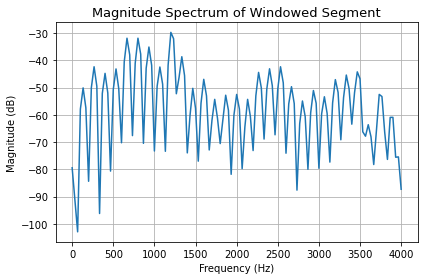

In [113]:
w = np.hamming(240)
segment = aa[len(aa)//2: len(aa)//2 + 240]

# fig = plt.figure(figsize = (10,5))
mag_spec = plt.magnitude_spectrum(segment, Fs = 8000, window = w, scale = 'dB')#, figure = fig)

plt.title('Magnitude Spectrum of Windowed Segment', fontsize = 13)
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.tight_layout();

In [114]:
len(segment)

240

### Observation: 

We see the formants in the narrorband magnitude spectrum which correspond to the formants of the vowel /a/. Because of pre-emphasis the roll-off is gentle and not as steep as the original sound spectrum

# Q3

With the same 30 ms segment of part 2, compute the autocorrelation coefficients
required for LPC calculation at various p = 2,4,6,8,10. Use the Levinson-Durbin
recursion to compute the LP coefficients from the autocorrelation coefficients. Plot error
signal energy (i.e. square of gain) vs p

In [115]:
def autocorr(segment, P = 2):
    N = len(segment)
    zeros = np.zeros(N * 2)
    zero_padded = zeros.copy()
    zero_padded[0:N] = segment
    r = []
    for i in range(0,P+1): #i = 1,2,...,P
        shifted = zeros.copy()
        shifted[i:(N+i)] = segment #segment shifted right by i samples, i.e segment[n-i]
        summ = np.sum(zero_padded * shifted) #summation over all n of segment[n]*segment[n-i]
        r.append(round(summ,3))
    return r

print("Autocorrelation coefficients for")
for P in [2,4,6,8,10]:
    print(f'P = {P}:', autocorr(segment, P))

Autocorrelation coefficients for
P = 2: [1.669, 1.014, 0.059]
P = 4: [1.669, 1.014, 0.059, -0.727, -1.031]
P = 6: [1.669, 1.014, 0.059, -0.727, -1.031, -0.681, -0.095]
P = 8: [1.669, 1.014, 0.059, -0.727, -1.031, -0.681, -0.095, 0.295, 0.078]
P = 10: [1.669, 1.014, 0.059, -0.727, -1.031, -0.681, -0.095, 0.295, 0.078, -0.049, -0.025]


p = 2
LP Coefficients: [ 0.92897036 -0.52904491]

p = 4
LP Coefficients: [ 0.69175782 -0.27504655 -0.16898666 -0.20402148]

p = 6
LP Coefficients: [ 0.71333706 -0.28329452 -0.16038121 -0.27771686  0.13341413 -0.08195799]

p = 8
LP Coefficients: [ 0.58482174 -0.22604464 -0.16594364 -0.49126605 -0.04706956 -0.09950707
  0.22426263 -0.59391883]

p = 10
LP Coefficients: [ 0.70476023 -0.23353573 -0.15985968 -0.47703473  0.0593624  -0.0339248
  0.28342568 -0.70874223  0.1818495   0.05902309]



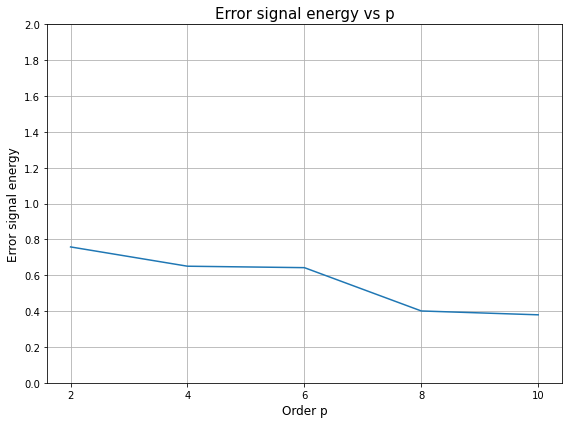

In [116]:
# LD Recursion

#ref: Page 198; Speech Communication, Human and Machine, by O'Shaughnessy

def LD_Recursion(R):
    '''
    r: list of autocorrelation values returned by autocorr function
    '''
    p = len(R) - 1
    E = np.zeros(p+1)
    E[0] = R[0]
    a = np.zeros((p+1,p+1))
    for m in range(1,p+1):
        summ = 0
        for k in range(1,m):
            summ += a[m-1][k] * R[m-k]
        km = (R[m] - summ)/E[m-1]
        a[m][m] = km
        for k in range(1,m):
            a[m][k] = a[m-1][k] - km* a[m-1][m-k]
        E[m] = (1-km**2)*E[m-1]
    G_sq = R[0] - np.sum(a[-1][1:] * R[1:])
        
    return a[-1][1:], E, G_sq       

LDR = lambda p,segment: LD_Recursion(autocorr(segment,p))

energy = []

for p in [2,4,6,8,10]:
    
    ak, E , G_sq = LDR(p,segment)
    print("p =", p)
    print("LP Coefficients: {}\n".format(ak))
    energy.append(G_sq)
    
plt.figure(figsize = (8,6))
plt.plot([2,4,6,8,10],energy)
plt.xlabel("Order p", fontsize = 12)
plt.ylabel("Error signal energy", fontsize = 12)
plt.xticks([2,4,6,8,10])
plt.yticks([x/10 for x in range(0,22,2)])
plt.title("Error signal energy vs p", fontsize = 15)
plt.grid()
plt.tight_layout();

### Observation: 

The error signal energy reduces with increasing p, which shows that as p increases, our LP analysis approximates the signal better and better

# Q4

Show the pole-zero plots of the estimated all-pole filter for p=6,10; comment.

In [117]:
# References:
# https://stackoverflow.com/questions/31556446/how-to-draw-axis-in-the-middle-of-the-figure
# https://stackoverflow.com/questions/8482588/putting-text-in-top-left-corner-of-matplotlib-plot
# https://www.tutorialspoint.com/showing-points-coordinates-in-a-plot-in-python-using-matplotlib
# https://stackoverflow.com/questions/29943871/how-to-draw-an-unit-circle-using-numpy-and-matplotlib
# https://stackoverflow.com/questions/31556446/how-to-draw-axis-in-the-middle-of-the-figure

def pole_zero_plot(P,segment):
    
    ak, E , G_sq = LDR(P,segment)
    Az = signal.TransferFunction([1],[1] + list(-ak), dt = 1/8000)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlim([-1.3,1.3])
    ax.set_ylim([-1.3,1.3])
    ax.set_title("Pole Zero Plot for P = {}".format(P), fontsize = 20)
    ax.spines['left'].set_position('center')
    # ax.spines['left'].set_position()
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xticks([x/10 for x in range(-12,13,2)])
    ax.set_yticks([x/10 for x in range(-12,13,2)])
    circ = plt.Circle((0, 0), radius=1, edgecolor='grey', facecolor='None')
    ax.add_patch(circ)
    ax.scatter(Az.poles.real, Az.poles.imag, marker = 'x', s = 100, color = 'r')
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth('2')

    for real, imag in zip(Az.poles.real, Az.poles.imag):
        if imag >= 0:
            plt.text(real, imag, '{} + j{}'.format(round(real,2), round(imag,2)), fontsize = 15,
                    ha='center', va='bottom')
        else:
            plt.text(real, imag, '{} - j{}'.format(round(real,2), round(-imag,2)), fontsize = 15,
                    ha='center', va='bottom')
    plt.show()

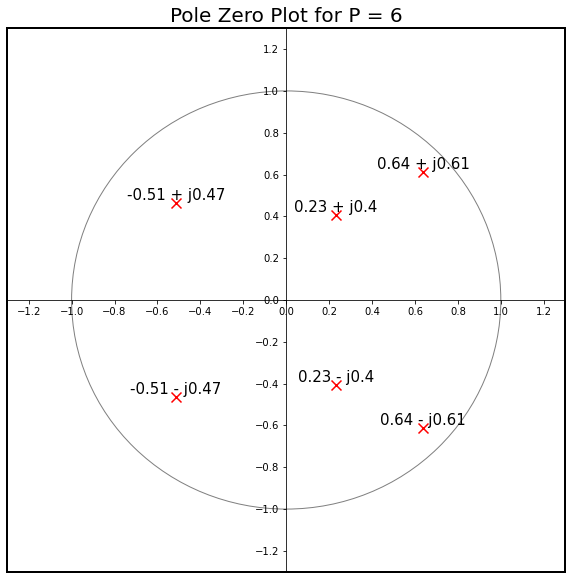

In [118]:
pole_zero_plot(6,segment)

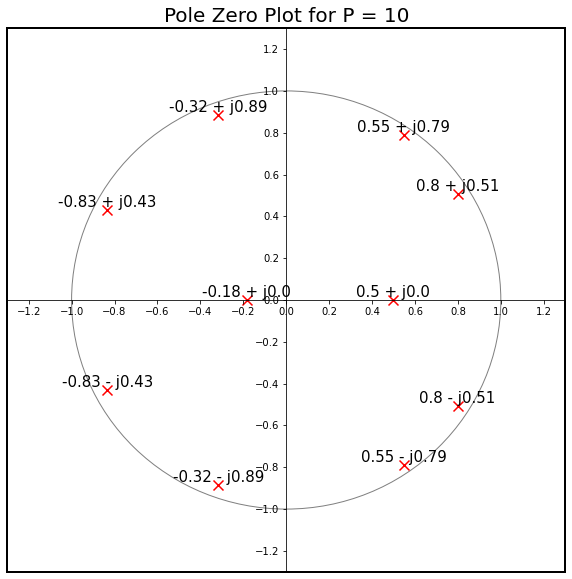

In [119]:
pole_zero_plot(10,segment)

### Observations: 

Shown above are the pole zero plots for estimated the all pole filters for p = 6,10. The number of poles is equal to p and they are either real or complex conjugates.

# Q5

Compute the gain and plot the LPC spectrum magnitude (i.e. the dB magnitude
frequency response of the estimated all-pole filter) for each order "p". Comment on the
characteristics of the spectral envelope estimates. Comment on their shapes with
reference to the short-time magnitude spectrum computed in part 2.

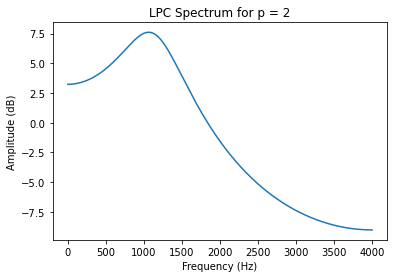

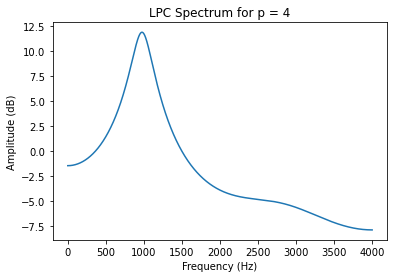

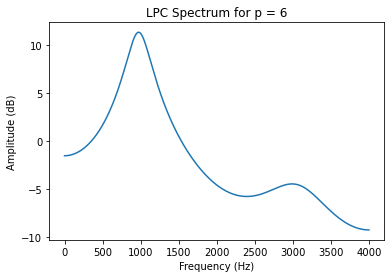

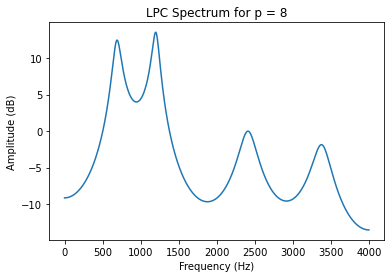

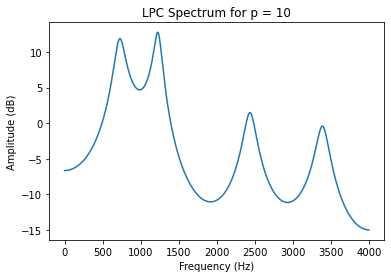

In [120]:
def LPC_spectrum(p,segment):
    ak, E , G_sq = LDR(p,segment)
    Az = signal.TransferFunction([1],[1] + list(-ak), dt = 1/8000)

    freq_resp = signal.dfreqresp(([1],[1] + list(-ak), 1/8000))

    plt.plot(freq_resp[0] * 4000/np.pi, 20*np.log10(np.sqrt(G_sq)*abs(freq_resp[1])))
#     plt.magnitude_spectrum(segment, Fs = 8000, window = w, scale = 'dB')
    plt.title("LPC Spectrum for p = {}".format(p))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.show()
    
for p in [2,4,6,8,10]:
    LPC_spectrum(p,segment)
    


### Observation: 
We see that as the value of p increases, the LPC spectrum resembles the magnitude spectrum more and more closely. For p = 2,4 we see only one peak in the spectrum. For p = 6, we see two peaks. For p = 8, 10, we are able to see the four formants corresponding to the four peaks in the spectrum. This is a good enough approximation of the spectral envelope (hidden envelope) of the speech signal which we are interested in

# Q6

Based on the 10th-order LP coefficients, carry out the inverse filtering of the /a/ vowel
segment to obtain the residual error signal. Can you measure the pitch period of the
voiced sound from the residual waveform? Use the acf to detect the pitch. Compare the
acf plots of the original speech and residual signals.

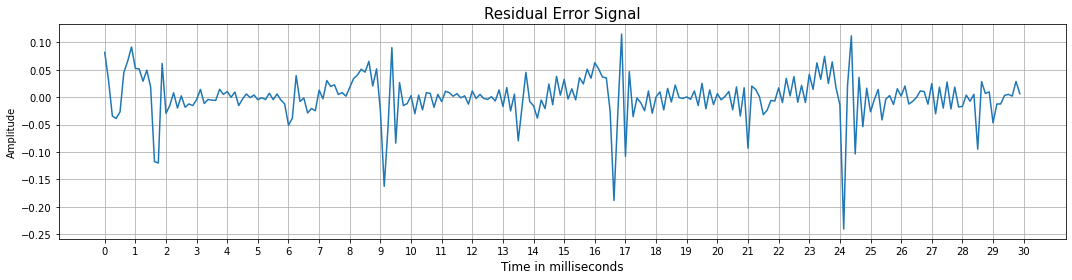

In [121]:
ak, E , G_sq = LDR(10,segment)

filtered = segment.copy()

for i,val in enumerate(segment):
    
    if i > 10:
        filtered[i] = segment[i] - sum(np.array(ak) * np.flip(segment[i-10:i]))
    
plt.figure(figsize = (15,4))
plt.plot(np.arange(len(filtered))/8,filtered)
plt.grid()
plt.xlabel("Time in milliseconds", fontsize = 12)
plt.ylabel("Amplitude")
plt.title("Residual Error Signal", fontsize = 15)
plt.tight_layout()
plt.xticks(list(range(0,31)))
plt.show();

# plt.figure(figsize = (15,4))
# plt.plot(np.arange(len(segment))/8,segment)
# plt.xlabel("Time in milliseconds")
# plt.grid()




#8000 samples per s
#therefore 1 sample = 1/8000 s

In [122]:
1000/7.5

133.33333333333334

In [123]:
#pitch period ~= 7.5 ms
# frequency (pitch) = 1000/7.5 = 133 Hz

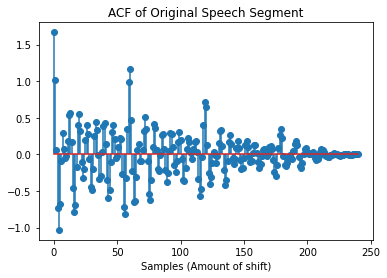

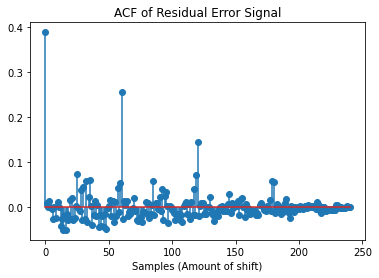

In [124]:
#Using ACF

acf = autocorr(segment, P = 240)
plt.stem(acf)
plt.title('ACF of Original Speech Segment')
plt.xlabel("Samples (Amount of shift)")
plt.show()

acf = autocorr(filtered, P = 240)
plt.stem(acf)
plt.title('ACF of Residual Error Signal')
plt.xlabel("Samples (Amount of shift)")
plt.show();

In [125]:
np.argmax(np.array(acf)[50:75])

10

In [126]:
acf[60]

0.256

In [127]:
sample_no = 60

def check_pitch(sample_no, num_checks = 10):
    for i in range(0,num_checks):
        if acf[sample_no] < acf[sample_no+i] or acf[sample_no] < acf[sample_no-i]:
            return False
    return True

print(check_pitch(59))
print(check_pitch(60))
print(check_pitch(61))

False
True
False


In [128]:
60/8000

0.0075

### Observations

We see the residual error signal and the ACF of the original speech segment and the residual error signal plotted. From the ACF we can see peaks at 0,60,120,...(units are 'samples'). To get the exact value, I have written some code in the function check_pitch which returns True if the input value is the exact pitch and False otherwise. We see that the exact pitch is **60 samples** which corresponds to a time period 60/8000 = 0.0075 s = **7.5 ms** which corresponds to a pitch of **133 Hz**

# Q7

LP re-synthesis: We analysed a natural speech sound /a/ above. Using a suitable set of
parameter estimates as obtained there, we wish to reconstruct the sound.

That is, use the best estimated LP filter with an ideal impulse train of the estimated pitch
period as source excitation. Carry out de-emphasis on the output waveform. Set the
duration of the synthesized sound to be 300 ms at 8 kHz sampling frequency and view
the waveform as well as listen to your created sound.

Comment on the similarity with the original sound. Try out voice modification using
this analysis-synthesis method (e.g. change the voice pitch).

## Answer

### De-emphasis:

$$ \frac{Y(z)}{X(z)} = \frac{1}{1-0.95z^{-1}} $$

$$ Y(z) - 0.95z^{-1}Y(z) = X(z) $$

$$ y[n] - 0.95 y[n-1] = x[n] $$

$$ y[n] = 0.95 y[n-1] + x[n] $$

In [129]:
dur = 0.3 #duration to play the sound
fs = 8000 #sampling rate
P = 60 #period of impulse train
num_samples = int(fs * dur)
imp_train = signal.unit_impulse(num_samples + 1, [x*P for x in range(0,int(num_samples/P) + 1)])
# plt.figure(figsize = (15,4))
# plt.stem(imp[0:140])

# pw = 20
# pulse = signal.windows.triang(pw + 1)
# pulse_train = signal.convolve(pulse, imp_train)

p = 8
ak, E, G_sq = LDR(p,segment)
filtered1 = imp_train.copy()
# filtered1 = pulse_train.copy()

for i,val in enumerate(imp_train):
    
    if i > p-1:
        filtered1[i] = sum(np.array(ak) * np.flip(imp_train[i-p:i]))

de_emph = filtered1.copy()

for i,val in enumerate(filtered[1:]):
    
    de_emph[i] = filtered1[i] + 0.95*de_emph[i-1]

In [130]:
Audio(de_emph, rate = 8000)

In [131]:
#2400 samples --> 2400 samples * (1/8000) seconds/sample = 0.3 seconds

## Observations:

De-emphasis incorporates the effects of lip radiation and glottal shaping again, which were removed by pre-emphasis. The resulting sound is similar to the original one but not same. Some formant information seems to have been lost, as the pronounciation is not clearly /a/.

# Q8

Optional (for bonus marks): Perform LP analysis on the provided /s/ sound (sampled at
16 kHz).

Autocorrelation coefficients for
P = 2: [0.371, -0.012, -0.312]
P = 4: [0.371, -0.012, -0.312, -0.012, 0.216]
P = 6: [0.371, -0.012, -0.312, -0.012, 0.216, 0.095, -0.167]
P = 8: [0.371, -0.012, -0.312, -0.012, 0.216, 0.095, -0.167, -0.154, 0.143]
P = 10: [0.371, -0.012, -0.312, -0.012, 0.216, 0.095, -0.167, -0.154, 0.143, 0.152, -0.09]
p = 2
LP Coefficients: [-0.05960857 -0.84289839]

p = 4
LP Coefficients: [-0.64027539 -1.46054034 -0.64027539 -0.68748031]

p = 6
LP Coefficients: [-0.50045441 -1.46659059 -0.4818207  -0.83703505  0.06172239 -0.18563174]

p = 8
LP Coefficients: [-0.42247971 -1.48806658 -0.20305311 -0.76601022  0.4513054  -0.1811791
  0.23992244 -0.09178946]

p = 10
LP Coefficients: [-0.43814423 -1.47668585 -0.2111565  -0.74096205  0.41221832 -0.25787284
  0.08684005 -0.24798168 -0.12562165 -0.08029821]



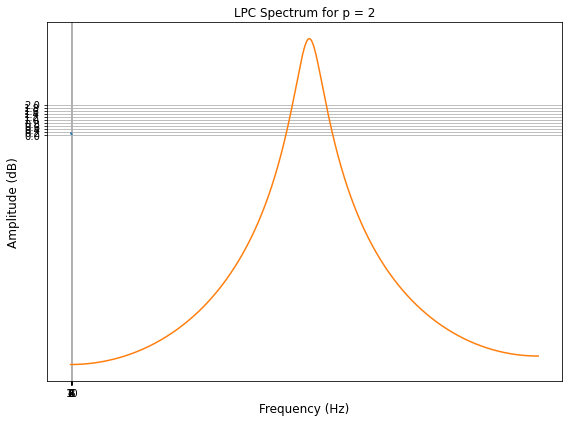

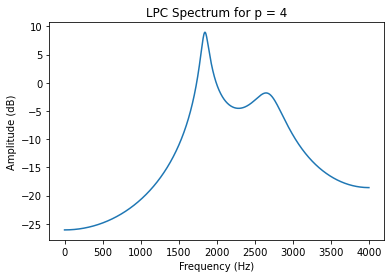

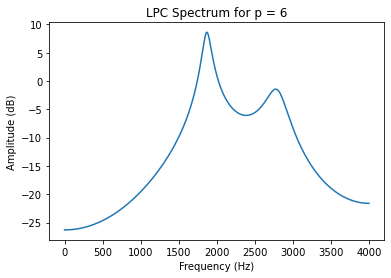

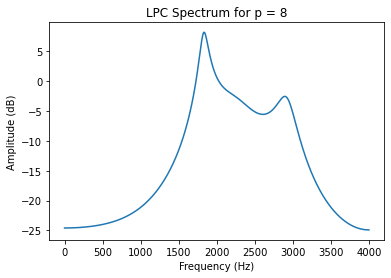

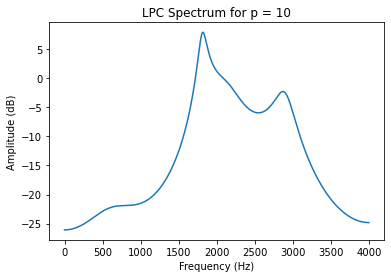

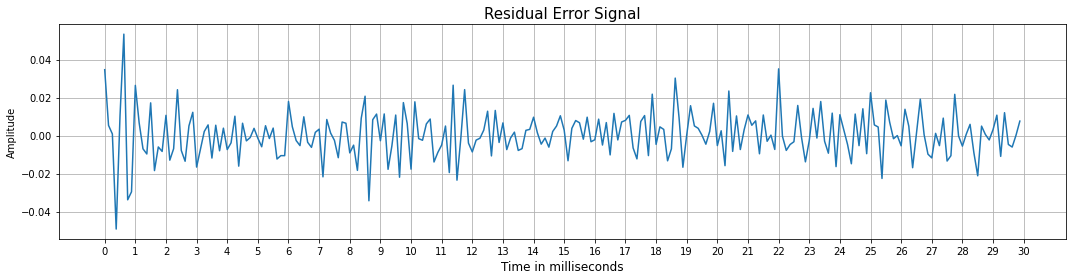

In [132]:
aa = ss

aa_shifted = 0.95 * np.array([0] + list(aa)[:-1]) #this is x[n-1]

aa_pre_emph = aa - aa_shifted #x[n] - x[n-1], vectorized to improve speed

pre_emph = aa.copy()
for i,val in enumerate(aa[0:]):
    
    pre_emph[i] = aa[i] - 0.95*aa[i-1]

aa = pre_emph


w = np.hamming(240)
segment_ss = aa[len(aa)//2: len(aa)//2 + 240]

print("Autocorrelation coefficients for")
for P in [2,4,6,8,10]:
    print(f'P = {P}:', autocorr(segment_ss, P))
    
energy = []
for p in [2,4,6,8,10]:
    
    ak, E , G_sq = LDR(p,segment_ss)
    print("p =", p)
    print("LP Coefficients: {}\n".format(ak))
    energy.append(G_sq)
    
plt.figure(figsize = (8,6))
plt.plot([2,4,6,8,10],energy)
plt.xlabel("Order p", fontsize = 12)
plt.ylabel("Error signal energy", fontsize = 12)
plt.xticks([2,4,6,8,10])
plt.yticks([x/10 for x in range(0,22,2)])
plt.title("Error signal energy vs p", fontsize = 15)
plt.grid()
plt.tight_layout();

for p in [2,4,6,8,10]:
    LPC_spectrum(p,segment_ss)
    
    
ak, E , G_sq = LDR(10,segment_ss)

filtered = segment_ss.copy()

for i,val in enumerate(segment_ss):
    
    if i > 10:
        filtered[i] = segment_ss[i] - sum(np.array(ak) * np.flip(segment_ss[i-10:i]))
    
plt.figure(figsize = (15,4))
plt.plot(np.arange(len(filtered))/8,filtered)
plt.grid()
plt.xlabel("Time in milliseconds", fontsize = 12)
plt.ylabel("Amplitude")
plt.title("Residual Error Signal", fontsize = 15)
plt.tight_layout()
plt.xticks(list(range(0,31)))
plt.show();

dur = 0.3 #duration to play the sound
fs = 16000 #sampling rate
P = 60 #period of impulse train
num_samples = int(fs * dur)
imp_train = signal.unit_impulse(num_samples + 1, [x*P for x in range(0,int(num_samples/P) + 1)])
# plt.figure(figsize = (15,4))
# plt.stem(imp[0:140])

# pw = 20
# pulse = signal.windows.triang(pw + 1)
# pulse_train = signal.convolve(pulse, imp_train)

p = 8
ak, E, G_sq = LDR(p,segment_ss)
filtered1 = imp_train.copy()
# filtered1 = pulse_train.copy()

for i,val in enumerate(imp_train):
    
    if i > p-1:
        filtered1[i] = sum(np.array(ak) * np.flip(imp_train[i-p:i]))

de_emph = filtered1.copy()

for i,val in enumerate(filtered[1:]):
    
    de_emph[i] = filtered1[i] + 0.95*de_emph[i-1]
    
Audio(de_emph, rate = 16000)

In [133]:
Audio(de_emph, rate = 16000)

## Observations

Because of the unvoices nature of /s/, it is not possible to re-construct the sound from the LP filter. On reconstruction and deemphasis we get a sound at 133.33 Hz which is not the same as the original sound 